In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import urllib.request
from numpy import mean, std, dstack
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
local_zip = "UCI_HAR_Dataset.zip"
urllib.request.urlretrieve(url, local_zip)

('UCI_HAR_Dataset.zip', <http.client.HTTPMessage at 0x7a8d9ef076d0>)

In [3]:
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack into a single 3D array
    loaded = dstack(loaded)
    return loaded

def load_dataset():
    print("Loading the dataset")
    # define filenames for train and test datasets
    trainX_files = [
        'train/Inertial Signals/total_acc_x_train.txt',
        'train/Inertial Signals/total_acc_y_train.txt',
        'train/Inertial Signals/total_acc_z_train.txt',
        'train/Inertial Signals/body_acc_x_train.txt',
        'train/Inertial Signals/body_acc_y_train.txt',
        'train/Inertial Signals/body_acc_z_train.txt',
        'train/Inertial Signals/body_gyro_x_train.txt',
        'train/Inertial Signals/body_gyro_y_train.txt',
        'train/Inertial Signals/body_gyro_z_train.txt'
    ]
    testX_files = [
        'test/Inertial Signals/total_acc_x_test.txt',
        'test/Inertial Signals/total_acc_y_test.txt',
        'test/Inertial Signals/total_acc_z_test.txt',
        'test/Inertial Signals/body_acc_x_test.txt',
        'test/Inertial Signals/body_acc_y_test.txt',
        'test/Inertial Signals/body_acc_z_test.txt',
        'test/Inertial Signals/body_gyro_x_test.txt',
        'test/Inertial Signals/body_gyro_y_test.txt',
        'test/Inertial Signals/body_gyro_z_test.txt'
    ]

    trainX = load_group(trainX_files, prefix='UCI HAR Dataset/')
    testX = load_group(testX_files, prefix='UCI HAR Dataset/')

    print("Loading target data")
    trainy = load_file('UCI HAR Dataset/train/y_train.txt')
    testy = load_file('UCI HAR Dataset/test/y_test.txt')

    # zero-offset the class values
    trainy = trainy - 1
    testy = testy - 1

    # one-hot encode the labels
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    print(f"Training data shape: {trainX.shape}")
    print(f"Testing data shape: {testX.shape}")
    print(f"Training labels shape: {trainy.shape}")
    print(f"Testing labels shape: {testy.shape}")

    return trainX, trainy, testX, testy


In [5]:
def evaluate_model(trainX, trainy, testX, testy):
    print("defining and evaluating LSTM model")
    verbose, epochs, batch_size = 0, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

    return accuracy, model

In [6]:
def evaluate_model_multiple_times(trainX, trainy, testX, testy, n_times=10):
    print(f"Evaluating model {n_times} times...")
    scores = []
    best_model = None
    best_accuracy = 0

    for i in range(n_times):
        accuracy, model = evaluate_model(trainX, trainy, testX, testy)
        print(f'> Run {i+1}: {accuracy:.3f}')
        scores.append(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    print(f'Summary: mean={mean(scores):.3f}, std={std(scores):.3f}, min={min(scores):.3f}, max={max(scores):.3f}')
    return scores, best_model


In [7]:
trainX, trainy, testX, testy = load_dataset()

Loading the dataset


<ipython-input-4-ce374b9a6bd4>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-4-ce374b9a6bd4>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-4-ce374b9a6bd4>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-4-ce374b9a6bd4>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-4-ce3

Loading target data
Training data shape: (7352, 128, 9)
Testing data shape: (2947, 128, 9)
Training labels shape: (7352, 6)
Testing labels shape: (2947, 6)


<ipython-input-4-ce374b9a6bd4>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-4-ce374b9a6bd4>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-4-ce374b9a6bd4>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)


In [8]:
scores, best_model = evaluate_model_multiple_times(trainX, trainy, testX, testy)

Evaluating model 10 times...
defining and evaluating LSTM model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


> Run 1: 0.910
defining and evaluating LSTM model
> Run 2: 0.909
defining and evaluating LSTM model
> Run 3: 0.907
defining and evaluating LSTM model
> Run 4: 0.902
defining and evaluating LSTM model
> Run 5: 0.891
defining and evaluating LSTM model
> Run 6: 0.846
defining and evaluating LSTM model
> Run 7: 0.911
defining and evaluating LSTM model
> Run 8: 0.910
defining and evaluating LSTM model
> Run 9: 0.909
defining and evaluating LSTM model
> Run 10: 0.882
Summary: mean=0.898, std=0.020, min=0.846, max=0.911


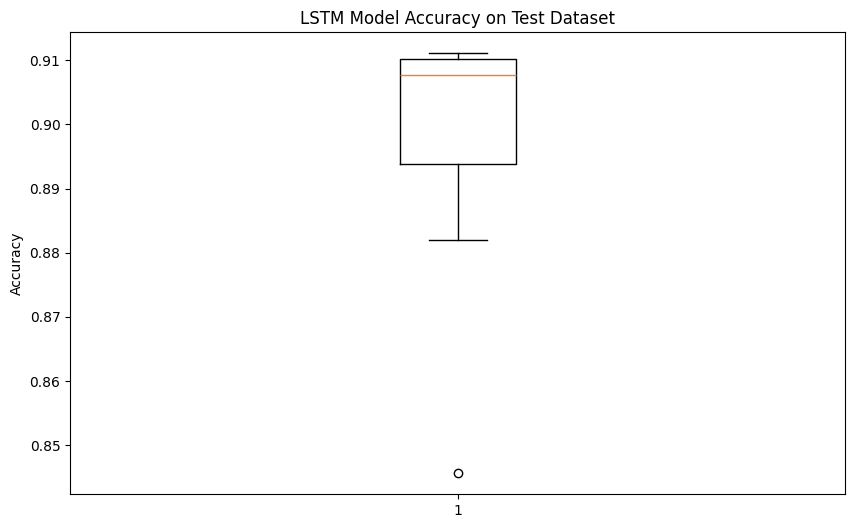

In [9]:
plt.figure(figsize=(10, 6))
plt.boxplot(scores)
plt.title('LSTM Model Accuracy on Test Dataset')
plt.ylabel('Accuracy')
plt.show()

In [10]:
activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


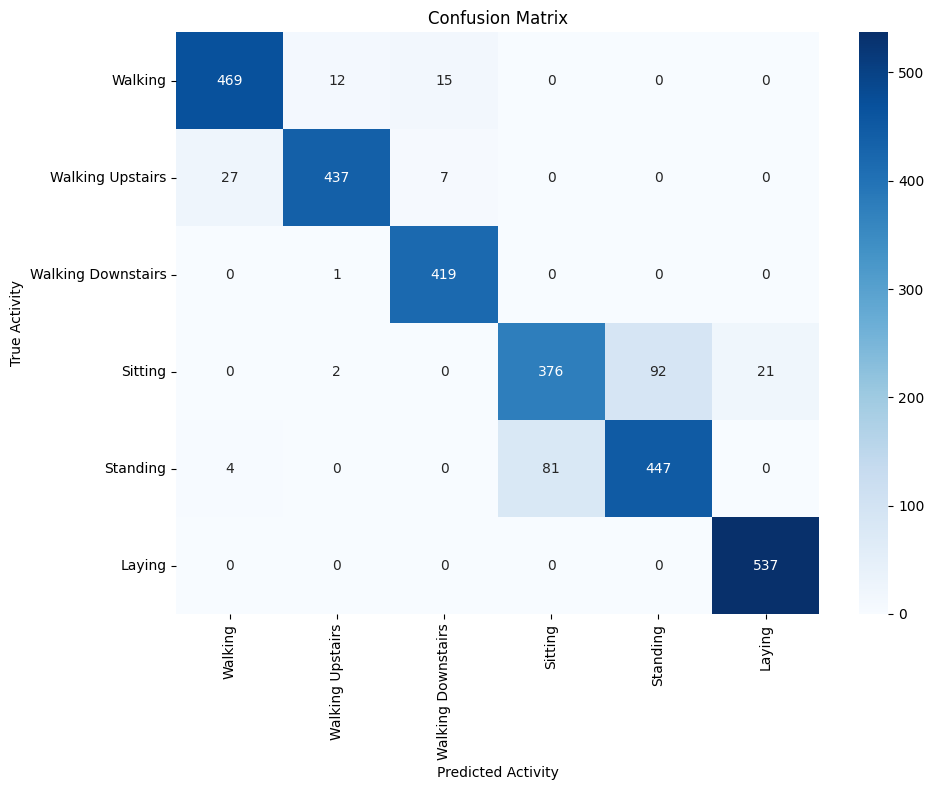

In [11]:
y_pred = best_model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(testy, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_names, yticklabels=activity_names)
plt.title('Confusion Matrix')
plt.ylabel('True Activity')
plt.xlabel('Predicted Activity')
plt.tight_layout()
plt.show()


Classification Report:
                    precision    recall  f1-score   support

           Walking       0.94      0.95      0.94       496
  Walking Upstairs       0.97      0.93      0.95       471
Walking Downstairs       0.95      1.00      0.97       420
           Sitting       0.82      0.77      0.79       491
          Standing       0.83      0.84      0.83       532
            Laying       0.96      1.00      0.98       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



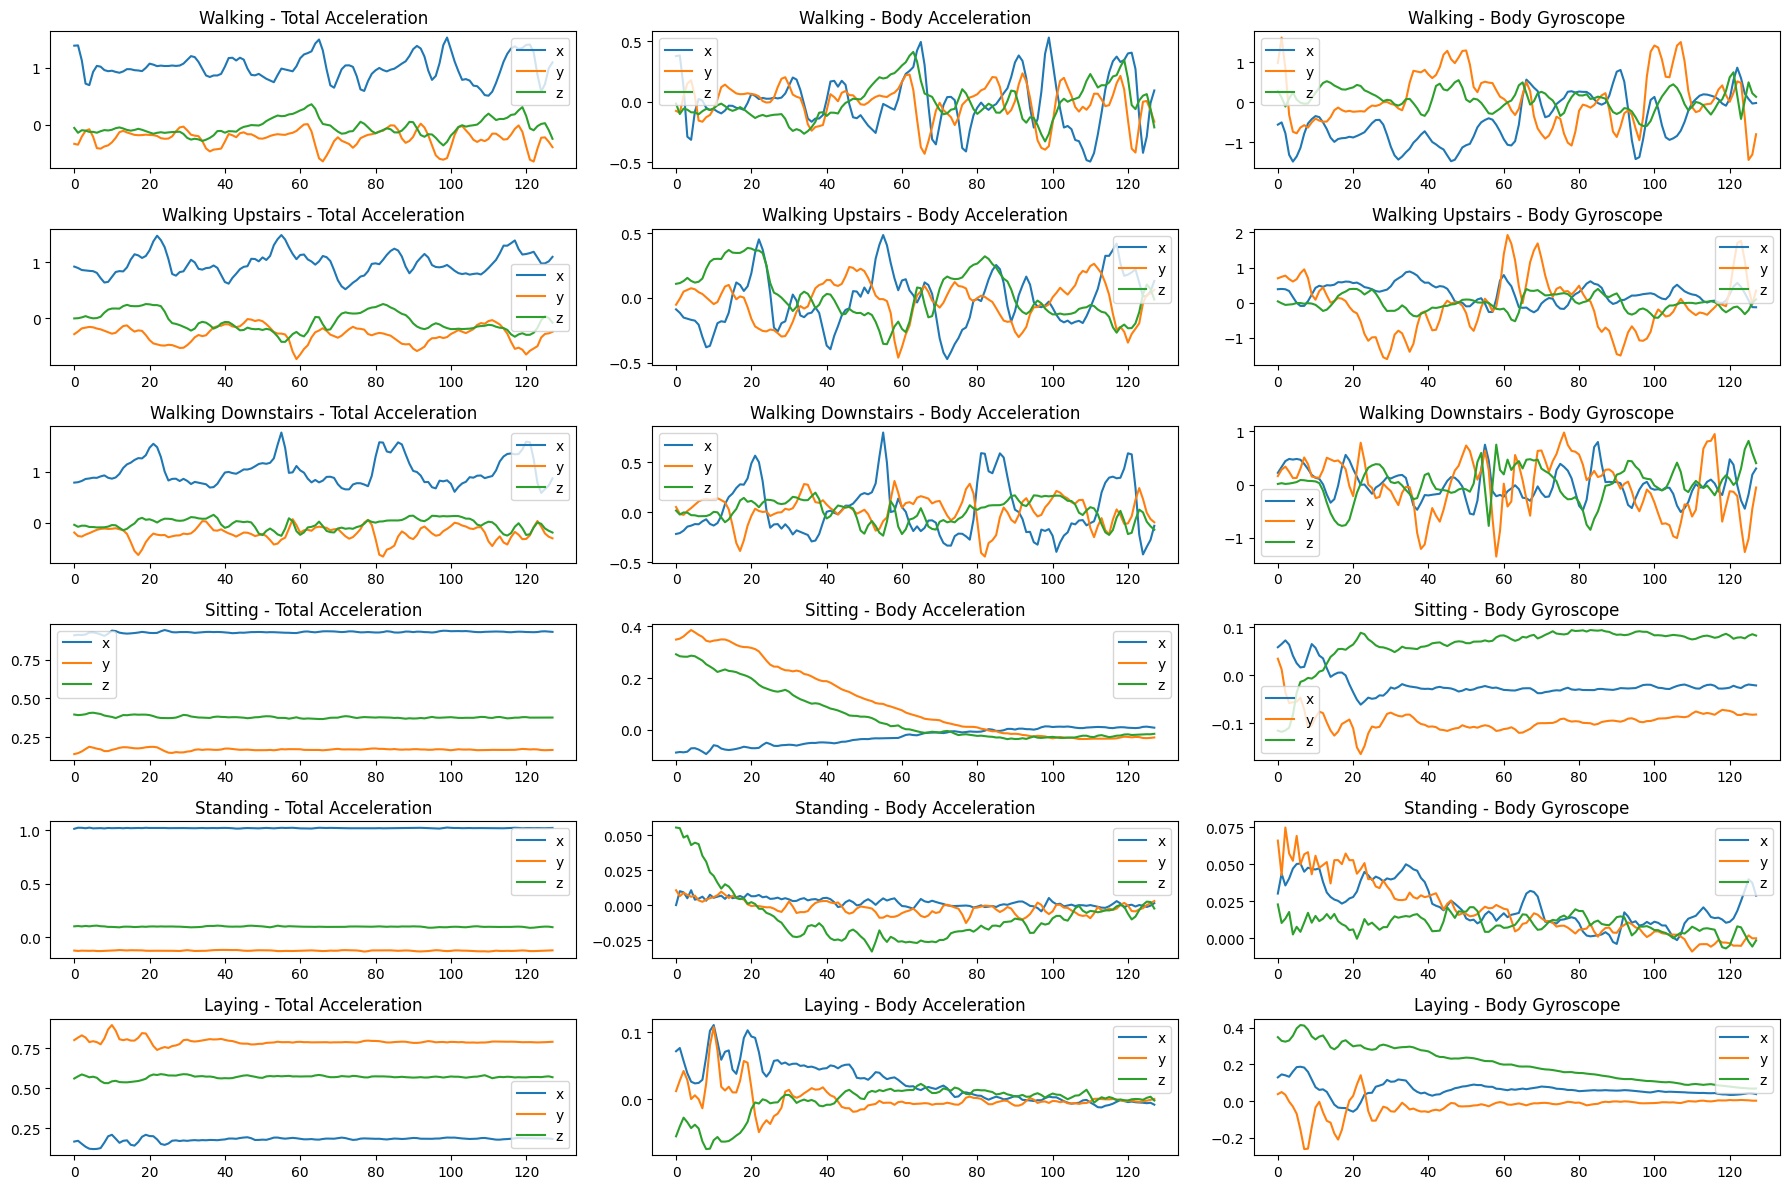

In [12]:
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=activity_names))

# visualize one example of each activity
def plot_example_activities(X, y):
    plt.figure(figsize=(18, 12))

    for i, activity_idx in enumerate(range(6)):
        # Find first instance of each activity
        indices = np.where(np.argmax(y, axis=1) == activity_idx)[0]
        if len(indices) > 0:
            idx = indices[0]

            # Get the data for this example
            example = X[idx]

            # Plot total acceleration for x, y, z axes
            plt.subplot(6, 3, i*3+1)
            plt.title(f'{activity_names[activity_idx]} - Total Acceleration')
            plt.plot(example[:, 0], label='x')
            plt.plot(example[:, 1], label='y')
            plt.plot(example[:, 2], label='z')
            plt.legend()

            # Plot body acceleration for x, y, z axes
            plt.subplot(6, 3, i*3+2)
            plt.title(f'{activity_names[activity_idx]} - Body Acceleration')
            plt.plot(example[:, 3], label='x')
            plt.plot(example[:, 4], label='y')
            plt.plot(example[:, 5], label='z')
            plt.legend()

            # Plot body gyroscope for x, y, z axes
            plt.subplot(6, 3, i*3+3)
            plt.title(f'{activity_names[activity_idx]} - Body Gyroscope')
            plt.plot(example[:, 6], label='x')
            plt.plot(example[:, 7], label='y')
            plt.plot(example[:, 8], label='z')
            plt.legend()

    plt.tight_layout()
    plt.show()

plot_example_activities(trainX, trainy)


# Report

## Why was this problem suitable for LSTM and not just any other machine learning algorithm?

- Human activity recognition involves sequential data where temporal dependencies are important.
- LSTM networks are specifically designed to capture long-term dependencies in time series data.
- Traditional ML algorithms typically don't handle sequential data well, as they treat each time step independently.
- The sensor data contains patterns across time that LSTMs can effectively learn, such as the repetitive nature of walking.


## Is a many-to-many model a more real-world scenario for this problem or a many-to-one model and why?


For this specific problem, a many-to-one model is appropriate because we're classifying entire windows of activity. However, in real-world continuous activity recognition, a many-to-many model would be more suitable. A many-to-many model would allow for continuous prediction of activities as new sensor data arrives. This enables real-time activity recognition and can detect transitions between activities, which is critical in practical applications.

## Explain the meaning of “Short Memory” and “Long Memory” in context of LSTMs.


Short Memory is the immediate information carried from the previous time step, represented by the hidden state. Long Memory is the information persisted over many time steps, maintained through the cell state.

## What are the three parts of an LSTM node and their functions?


The first part chooses whether the information coming from the previous timestamp is to be remembered or is irrelevant and can be forgotten. In the second part, the cell tries to learn new information from the input to this cell. At last, in the third part, the cell passes the updated information from the current timestamp to the next timestamp. This one cycle of LSTM is considered a single-time step. These three parts of an LSTM unit are known as gates. They control the flow of information in and out of the memory cell or lstm cell. The first gate is called Forget gate, the second gate is known as the Input gate, and the last one is the Output gate.

## What problems to RNNs face that LSTMs are able to adapt to fix?

LSTM is a type of RNN with higher memory power to remember the outputs of each node for a more extended period to produce the outcome for the next node efficiently. LSTM networks combat the RNN's vanishing gradients or long-term dependence issue.